<a href="https://colab.research.google.com/github/wkabbani/pytorch-playground/blob/main/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Classification

## 02.00. Setup

In [1]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    Args:
    dir_path (str): target directory

    Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
    
    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

## 02.01. Data

In [2]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
print(X[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [4]:
print(y[:5])

[1 1 1 1 0]


In [5]:
circles = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "y":  y
})
circles.head(5)

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [6]:
# how many values of each class is there?
circles.y.value_counts()

1    500
0    500
Name: y, dtype: int64

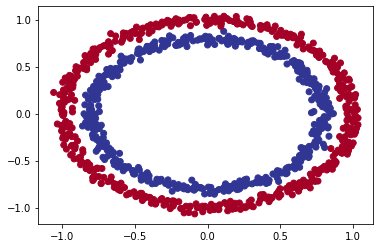

In [7]:
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

In [10]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [11]:
X.ndim, y.ndim

(2, 1)

In [12]:
X[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 02.02. Model V0

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [16]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

In [17]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
# another equivalent way of building the same model
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
y_logits = model_0(X_test.to(device))

In [26]:
y_logits.shape

torch.Size([200, 1])

In [27]:
y_logits.ndim

2

In [28]:
y_logits[:5]

tensor([[-0.4986],
        [-0.5874],
        [-0.1975],
        [-0.5842],
        [-0.0891]], grad_fn=<SliceBackward0>)

In [23]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [24]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [30]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.3779],
        [0.3572],
        [0.4508],
        [0.3580],
        [0.4777]], grad_fn=<SliceBackward0>)

In [32]:
y_preds = torch.round(y_pred_probs)
y_preds[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SliceBackward0>)

In [33]:
torch.eq(y_preds.squeeze(), y_test.squeeze())

tensor([False,  True, False,  True, False, False,  True,  True, False,  True,
         True, False,  True, False,  True, False, False,  True, False,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True, False,  True, False, False, False, False, False,
        False, False, False,  True,  True, False,  True,  True, False, False,
         True,  True,  True,  True, False,  True, False, False, False,  True,
        False,  True,  True, False, False, False, False,  True,  True,  True,
        False,  True,  True, False, False, False, False,  True,  True, False,
         True, False,  True, False, False, False,  True,  True,  True,  True,
        False, False, False, False, False,  True, False, False,  True, False,
         True,  True, False, False,  True,  True, False,  True,  True, False,
        False, False,  True, False, False,  True, False,  True, False,  True,
        False,  True,  True, False, False,  True, False, False, 

In [34]:
y_preds.squeeze()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [37]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  # set the model in training mode
  model_0.train()

  # forward pass
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # calculate the loss
  loss = loss_fn(y_logits, y_train)

  # calculate the accuracy
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  # reset grads
  optimizer.zero_grad()

  # calculate new grads
  loss.backward()

  # update parameters
  optimizer.step()

  # set the model in eval mode
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch}: Train loss: {loss:.4f}, Test loss: {test_loss:.4f}, Train acc: {acc:.2f}, Test acc: {test_acc:.2f}')

Epoch: 0: Train loss: 0.6950, Test loss: 0.6919, Train acc: 48.75, Test acc: 50.50
Epoch: 10: Train loss: 0.6948, Test loss: 0.6920, Train acc: 49.38, Test acc: 49.50
Epoch: 20: Train loss: 0.6946, Test loss: 0.6921, Train acc: 48.88, Test acc: 50.00
Epoch: 30: Train loss: 0.6944, Test loss: 0.6923, Train acc: 49.12, Test acc: 50.00
Epoch: 40: Train loss: 0.6943, Test loss: 0.6924, Train acc: 49.12, Test acc: 50.50
Epoch: 50: Train loss: 0.6942, Test loss: 0.6925, Train acc: 49.00, Test acc: 51.00
Epoch: 60: Train loss: 0.6941, Test loss: 0.6926, Train acc: 49.38, Test acc: 50.50
Epoch: 70: Train loss: 0.6940, Test loss: 0.6927, Train acc: 49.50, Test acc: 49.50
Epoch: 80: Train loss: 0.6939, Test loss: 0.6928, Train acc: 49.38, Test acc: 49.00
Epoch: 90: Train loss: 0.6938, Test loss: 0.6929, Train acc: 49.50, Test acc: 48.50


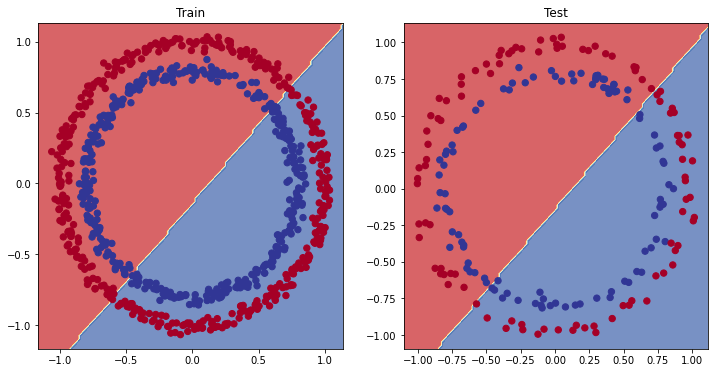

In [39]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 02.03. Model V1

In [40]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [41]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [42]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  # set the model in training mode
  model_1.train()

  # forward pass
  y_logits = model_1(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # calculate the loss
  loss = loss_fn(y_logits, y_train)

  # calculate the accuracy
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  # reset grads
  optimizer.zero_grad()

  # calculate new grads
  loss.backward()

  # update parameters
  optimizer.step()

  # set the model in eval mode
  model_1.eval()

  # evaluate on the test set
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch}: Train loss: {loss:.4f}, Test loss: {test_loss:.4f}, Train acc: {acc:.2f}, Test acc: {test_acc:.2f}')

Epoch: 0: Train loss: 0.6940, Test loss: 0.6926, Train acc: 50.88, Test acc: 51.00
Epoch: 10: Train loss: 0.6937, Test loss: 0.6927, Train acc: 50.25, Test acc: 50.00
Epoch: 20: Train loss: 0.6935, Test loss: 0.6928, Train acc: 50.12, Test acc: 49.50
Epoch: 30: Train loss: 0.6934, Test loss: 0.6930, Train acc: 50.50, Test acc: 48.00
Epoch: 40: Train loss: 0.6933, Test loss: 0.6931, Train acc: 50.38, Test acc: 49.00
Epoch: 50: Train loss: 0.6932, Test loss: 0.6932, Train acc: 49.88, Test acc: 50.00
Epoch: 60: Train loss: 0.6932, Test loss: 0.6934, Train acc: 49.38, Test acc: 51.50
Epoch: 70: Train loss: 0.6931, Test loss: 0.6935, Train acc: 49.38, Test acc: 50.50
Epoch: 80: Train loss: 0.6931, Test loss: 0.6936, Train acc: 50.12, Test acc: 50.00
Epoch: 90: Train loss: 0.6931, Test loss: 0.6937, Train acc: 50.50, Test acc: 48.50
Epoch: 100: Train loss: 0.6930, Test loss: 0.6938, Train acc: 50.38, Test acc: 48.00
Epoch: 110: Train loss: 0.6930, Test loss: 0.6939, Train acc: 50.88, Test ac

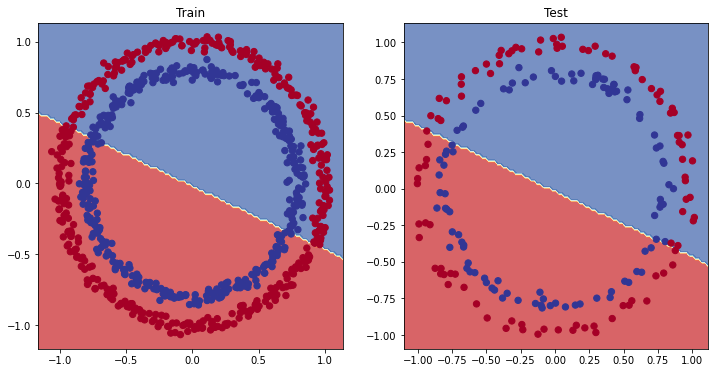

In [43]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 02.04. Model V2

In [44]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [45]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [46]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  # set the model in training mode
  model_2.train()

  # forward pass
  y_logits = model_2(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # calculate the loss
  loss = loss_fn(y_logits, y_train)

  # calculate the accuracy
  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  # reset grads
  optimizer.zero_grad()

  # calculate new grads
  loss.backward()

  # update parameters
  optimizer.step()

  # set the model in eval mode
  model_2.eval()

  # evaluate on the test set
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch}: Train loss: {loss:.4f}, Test loss: {test_loss:.4f}, Train acc: {acc:.2f}, Test acc: {test_acc:.2f}')

Epoch: 0: Train loss: 0.6929, Test loss: 0.6932, Train acc: 50.00, Test acc: 50.00
Epoch: 10: Train loss: 0.6925, Test loss: 0.6926, Train acc: 50.50, Test acc: 50.00
Epoch: 20: Train loss: 0.6922, Test loss: 0.6923, Train acc: 59.13, Test acc: 56.50
Epoch: 30: Train loss: 0.6921, Test loss: 0.6921, Train acc: 70.25, Test acc: 68.00
Epoch: 40: Train loss: 0.6919, Test loss: 0.6919, Train acc: 68.38, Test acc: 71.00
Epoch: 50: Train loss: 0.6918, Test loss: 0.6918, Train acc: 58.25, Test acc: 58.00
Epoch: 60: Train loss: 0.6917, Test loss: 0.6916, Train acc: 54.00, Test acc: 54.50
Epoch: 70: Train loss: 0.6915, Test loss: 0.6915, Train acc: 53.12, Test acc: 53.00
Epoch: 80: Train loss: 0.6914, Test loss: 0.6913, Train acc: 52.62, Test acc: 53.00
Epoch: 90: Train loss: 0.6913, Test loss: 0.6912, Train acc: 52.75, Test acc: 53.00
Epoch: 100: Train loss: 0.6912, Test loss: 0.6910, Train acc: 52.88, Test acc: 52.50
Epoch: 110: Train loss: 0.6910, Test loss: 0.6909, Train acc: 52.88, Test ac

In [47]:
# Make predictions
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

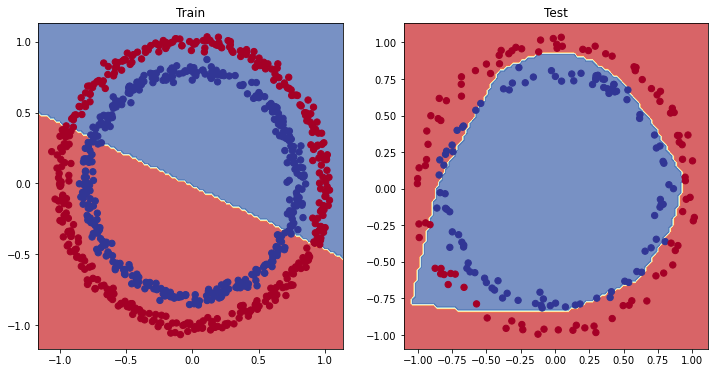

In [48]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)